# High Order Symplectic Integrators

This notebooks show how to use the high order symplectic integrators of Wisdom et al. (1996) and Laskar & Robutel (2001) with REBOUND. See  Rein, Tamayo & Brown (2019) for an overview of these integrators. 

Let us start by importing REBOUND, as well as numpy and matplotlib.

In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

High order symplectic integrators with a fixed timestep are well suited for planetary systems in which planets orbit the primary mass on almost Keplerian orbits. The planet-planet interactions need to be a perturbation. If they are not, a different integrator, such as IAS15 or MERCURIUS is better suited.

On system that we know is stable is the outer Solar System. So we will use this as our test case. We can either import accurate data from NASA Horizons, or, because this is just a test, use some of the initial conditions which come with REBOUND to setup a simulation.

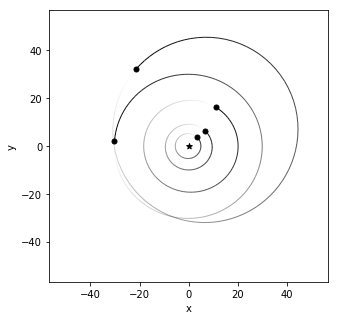

In [2]:
from rebound import data
sim = rebound.Simulation()
data.add_outer_solar_system(sim) # either this, or add the planets manually
rebound.OrbitPlot(sim);

We'll integrate the outer Solar System for 1000 years into the future and measure the energy error along the way. We do that at random intervals to make sure we don't have any aliasing with an orbital period. The following function runs the simulation, and then returns the error.

In [3]:
def measure_energy(sim):
    Nsamples = 1000
    tmax = 2.*np.pi*1e3 # 1000 years
    t_samples = tmax*np.sort(np.random.random(Nsamples))
    E0 = sim.calculate_energy() # initial energy
    Emax = 0. # maximum energy error
    for t in t_samples:
        # we do not want to change the timestep to reach t exactly, thus 
        # we need to set exact_finish_time=False and slighlty overshoot.
        sim.integrate(t,exact_finish_time=False) 
        E = sim.calculate_energy()
        Emax = max(Emax, np.abs((E-E0)/E0))
    return Emax

To get an idea how our integrators are behaving, we want to run this simulation for various timesteps. So let us set up an array of timesteps from 0.001 to 1 orbital periods of Jupiter.

In [4]:
N_dt_samples = 100
dt_samples = sim.particles[1].P * np.logspace(-3,0.,N_dt_samples)

Let's run the simulations with the standard WH integrator first. We set `safe_mode` to 0 to speed up the calculation.

In [5]:
Emax_wh = np.zeros(N_dt_samples)
for i, dt in enumerate(dt_samples):
    sim_run = sim.copy() # make a copy of the simulation so we don't need to set a new one up every time
    sim_run.integrator = "whfast"
    sim_run.dt = dt
    sim.ri_whfast.safe_mode = False
    Emax_wh[i] = measure_energy(sim_run)

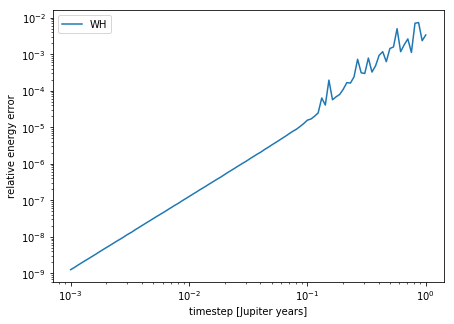

In [6]:
f,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("timestep [Jupiter years]")
ax.set_ylabel("relative energy error")
ax.plot(dt_samples/sim.particles[1].P,Emax_wh,label="WH")
ax.legend();

We can see that the WH converges quadratically and reaches a precision of $10^{-9}$ at a timestep of 0.001 Jupiter years. Let's try the same with the WHCKL and SABACL4 integrators.

In [7]:
Emax_saba4 = np.zeros(N_dt_samples)
for i, dt in enumerate(dt_samples):
    sim_run = sim.copy() # make a copy of the simulation so we don't need to set a new one up every time
    sim_run.integrator = "saba"
    sim_run.ri_saba.k = 4 # SABACL4
    sim_run.ri_saba.corrector = "lazy"
    sim_run.ri_saba.safe_mode = False
    sim_run.dt = dt
    Emax_saba4[i] = measure_energy(sim_run)
Emax_whckl = np.zeros(N_dt_samples)
for i, dt in enumerate(dt_samples):
    sim_run = sim.copy() # make a copy of the simulation so we don't need to set a new one up every time
    sim_run.integrator = "whfast" 
    sim_run.ri_whfast.kernel = "lazy"
    sim_run.ri_whfast.corrector = 17 # first symplectic correctors of order 17
    sim_run.ri_whfast.safe_mode = False
    sim_run.dt = dt
    Emax_whckl[i] = measure_energy(sim_run)

/Users/rein/git/rebound/rebound/simulation.py:621: RuntimeWarning: WHFast convergence issue. Timestep is larger than at least one orbital period.
  warnings.warn(msg[1:], RuntimeWarning)


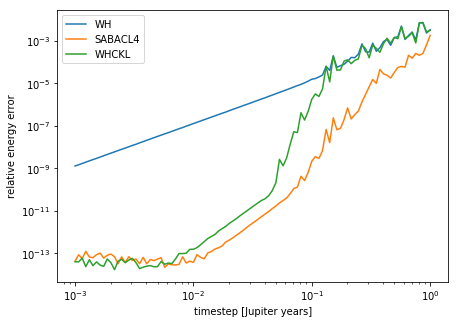

In [8]:
f,ax = plt.subplots(1,1,figsize=(7,5))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("timestep [Jupiter years]")
ax.set_ylabel("relative energy error")
ax.plot(dt_samples/sim.particles[1].P,Emax_wh,label="WH")
ax.plot(dt_samples/sim.particles[1].P,Emax_saba4,label="SABACL4")
ax.plot(dt_samples/sim.particles[1].P,Emax_whckl,label="WHCKL")
ax.legend();

We can see that both SABA4 and WHCKL are doing significantly better than the standard WH method. For very small timesteps both methods are limited by double floating point precision. The SABACL4 method does slightly better than the WHCKL method above, but note that the SABACL4 method is about a factor of 3 slower than WHCKL. Taking this into account, the WHCKL has a slight advantage.

If you just want to the WHCKL method, there is a shortcut to setup all the WHFast settings:

In [9]:
sim.integrator = "whckl"

You still need to set `sim.ri_whfast.safe_mode` and `sim.ri_whfast.keep_unsynchronized` depending on your needs.